# Réseaux convolutionnels : CNN

## X_Ray image analysis

## Initialisations

In [1]:
# Directive pour afficher les graphiques dans Jupyter
%matplotlib inline

# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import datasets

In [2]:
from keras.datasets import mnist

from keras.models import Sequential, load_model

from keras.layers import Dense, Dropout, Flatten

from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
# Permet d'éviter les erreurs mémoires pour le GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Lecture des images

Sur kaggle, dataset "Chest X-Ray Images (Pneumonia)"
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Pour une installation locale :
pip install opencv-python


In [4]:
import cv2
import os
import glob

In [5]:
"""
# Ensure the data is lokated in the current working directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

"\n# Ensure the data is lokated in the current working directory\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

On parcourt le répertoire des images de poumons normaux (sans pneumonie, cible *y* à 0)

In [6]:
img_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/" 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
X=[]
y=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (150,150))
    X.append(np.array(img))
    y.append(0)

Text(0.5, 1.0, '0')

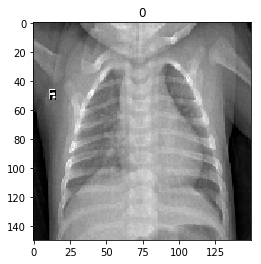

In [7]:
plt.imshow(X[0])
plt.title(y[0])

In [8]:
X[0].shape

(150, 150, 3)

On parcourt le répertoire des images indiquant une pneumonie (cible *y* à 1)

In [9]:
img_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/"
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (150,150))
    X.append(np.array(img))
    y.append(1)

Text(0.5, 1.0, '1')

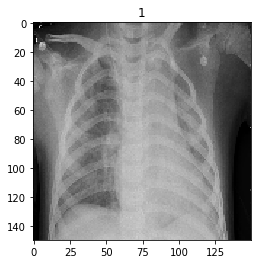

In [10]:
plt.imshow(X[len(X)-1])
plt.title(y[len(X)-1])

In [11]:
len(X)

5216

In [12]:
len(y)

5216

#### Ici on transforme X et y en des matrices pour le traitement et l'utilisation par la suite

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
# Normalisation entre 0 et 1
"""
forçage de type en float32, en suite diviser par 255 pour rendre les valeurs des pixels entre 0 et 1.
cette normalisation est nécessaire pour des calculs intenses comme le cas des CNN.
"""
X = X.astype('float32') / 255

In [15]:
print(y[0])

0


In [16]:
y = to_categorical(y)
print(y[0])

[1. 0.]


In [17]:
y.shape

(5216, 2)

In [18]:
num_classes = y.shape[1]
print(num_classes)

2


### Créer la training-set et la test-set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state= 1)

## Un modèle simple pour commencer

In [20]:
# Réseau simple 
model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(num_classes, activation ='softmax'))

# Compilation du modèle 
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [21]:
# Apprentissage

train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size= 200, verbose=1)

Train on 4172 samples, validate on 1044 samples
Epoch 1/20
4172/4172 [==============================] - 2s 448us/step - loss: 14.4722 - accuracy: 0.6117 - val_loss: 2.7829 - val_accuracy: 0.7423
Epoch 2/20
4172/4172 [==============================] - 1s 208us/step - loss: 1.2380 - accuracy: 0.7999 - val_loss: 0.5281 - val_accuracy: 0.8793
Epoch 3/20
4172/4172 [==============================] - 1s 239us/step - loss: 0.3797 - accuracy: 0.8895 - val_loss: 0.2849 - val_accuracy: 0.8908
Epoch 4/20
4172/4172 [==============================] - 1s 208us/step - loss: 0.2251 - accuracy: 0.9195 - val_loss: 0.1556 - val_accuracy: 0.9473
Epoch 5/20
4172/4172 [==============================] - 1s 213us/step - loss: 0.1537 - accuracy: 0.9408 - val_loss: 0.1231 - val_accuracy: 0.9588
Epoch 6/20
4172/4172 [==============================] - 1s 208us/step - loss: 0.1334 - accuracy: 0.9509 - val_loss: 0.1193 - val_accuracy: 0.9598
Epoch 7/20
4172/4172 [==============================] - 1s 266us/step - los

In [22]:
# Test

scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 93.20%


Ce réseau simple a conduit à une prédiction juste à 95% de bons résultats. Par la suite, on élabore un peu notre modèle pour des résultats plus justes.

### Un modèle plus profond

In [23]:
# Réseaux plus profond

# Réseau simple 
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape= (150, 150, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(num_classes, activation ='softmax'))

# Compilation du modèle 
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 170528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               21827712  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 21,830,402
Trainable params: 21,830,402
Non-trainable params: 0
_________________________________________________________________


In [25]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size= 200, verbose=1)

Train on 4172 samples, validate on 1044 samples
Epoch 1/20
4172/4172 [==============================] - 5s 1ms/step - loss: 1.5654 - accuracy: 0.7634 - val_loss: 0.1914 - val_accuracy: 0.9397
Epoch 2/20
4172/4172 [==============================] - 2s 486us/step - loss: 0.1851 - accuracy: 0.9317 - val_loss: 0.1088 - val_accuracy: 0.9703
Epoch 3/20
4172/4172 [==============================] - 2s 495us/step - loss: 0.0936 - accuracy: 0.9667 - val_loss: 0.0794 - val_accuracy: 0.9761
Epoch 4/20
4172/4172 [==============================] - 2s 481us/step - loss: 0.0620 - accuracy: 0.9784 - val_loss: 0.0719 - val_accuracy: 0.9789
Epoch 5/20
4172/4172 [==============================] - 2s 478us/step - loss: 0.0452 - accuracy: 0.9873 - val_loss: 0.0700 - val_accuracy: 0.9780
Epoch 6/20
4172/4172 [==============================] - 2s 480us/step - loss: 0.0387 - accuracy: 0.9892 - val_loss: 0.0779 - val_accuracy: 0.9761
Epoch 7/20
4172/4172 [==============================] - 2s 476us/step - loss: 

C'est étonnant de voire que l'**accuracy** est égale à 1 dès le tour 13. en fait comme on a une "**batch size**" de 200, et vu qu'on a déja une très bonne prédiction dans le résau normale, on peut alors s'attendre sur les 200 échantillons pris à chaque fois, on trouve une valeur proche de 1. Mais la valeur plus juste est celle qu'on verra par la suite.

In [26]:
# Test

scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 97.80%


#### La vrai **vrai ...! ** accuracy est 97% au lieu de 1 !

In [27]:
print(train.history['accuracy'])

[0.76342285, 0.9316874, 0.9666827, 0.9784276, 0.9872963, 0.9892138, 0.9767498, 0.99400765, 0.99544585, 0.9966443, 0.9992809, 0.9997603, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [28]:
print(train.history['val_accuracy'])

[0.9396551847457886, 0.9703065156936646, 0.9760536551475525, 0.9789271950721741, 0.9779693484306335, 0.9760536551475525, 0.975095808506012, 0.9798850417137146, 0.9712643623352051, 0.9779693484306335, 0.9818007946014404, 0.982758641242981, 0.9808428883552551, 0.9798850417137146, 0.9798850417137146, 0.9808428883552551, 0.9808428883552551, 0.9808428883552551, 0.9798850417137146, 0.9779693484306335]


In [29]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(0,len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

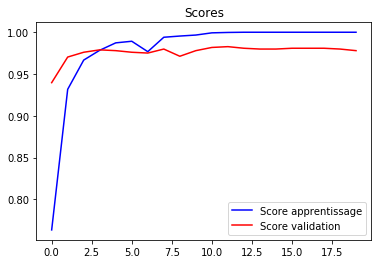

In [30]:
plot_scores(train)

In [31]:
# Prediction
y_cnn = model.predict(X_test)

In [32]:
print(y_cnn[0])

[0.9851554  0.01484458]


In [33]:
print(y_cnn[0].argmax(axis=-1))

0


In [34]:
y_cnn_classe = y_cnn.argmax(axis=-1)
y_test_classe = y_test.argmax(axis=-1)

[[254   8]
 [ 15 767]]


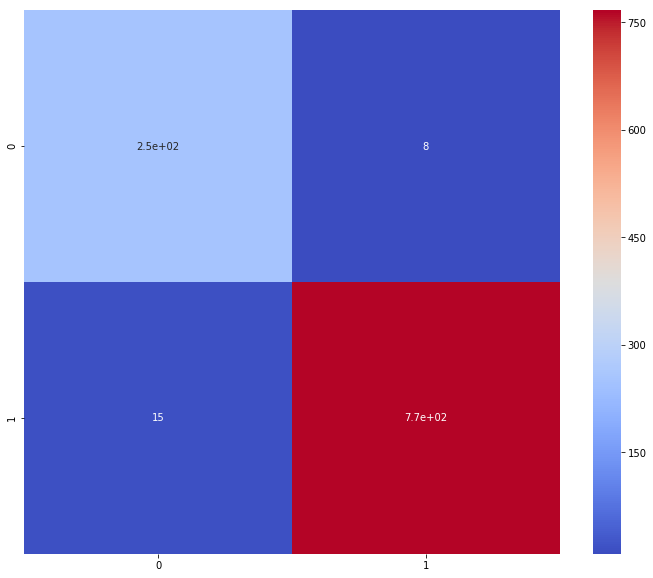

In [35]:
cm = confusion_matrix(y_cnn_classe,y_test_classe)
print(cm)
plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, cmap="coolwarm")

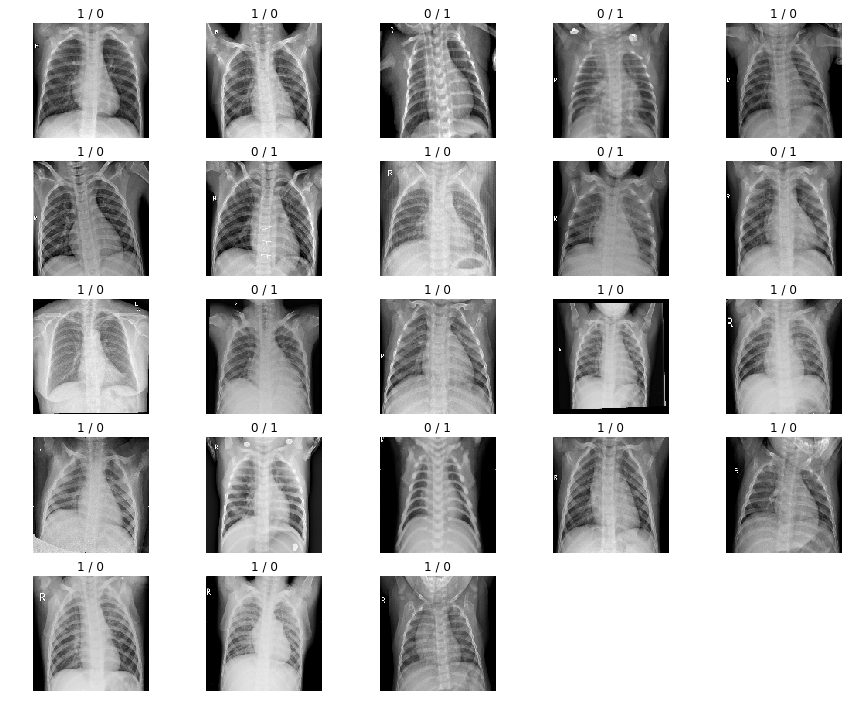

In [36]:
import random

plt.figure(figsize=(15,25))
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (np.argmax(y_cnn[j])!= np.argmax(y_test[j])) & (i<50):
        plt.subplot(10,5,i)
        plt.axis('off')
        plt.imshow(X_test[j], cmap='Greys')
        pred_classe = y_cnn[j].argmax(axis=-1)
        plt.title('%d / %d' % (np.argmax(y_cnn[j]), np.argmax(y_test[j])))
        i+=1

# Modèle plus profond

In [37]:
# Modèle CNN plus profond
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation= 'relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 78400)            

In [39]:
# Apprentissage
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=300, verbose=1)

Train on 4172 samples, validate on 1044 samples
Epoch 1/10
4172/4172 [==============================] - 4s 1ms/step - loss: 2.3209 - accuracy: 0.7428 - val_loss: 0.5845 - val_accuracy: 0.7423
Epoch 2/10
4172/4172 [==============================] - 3s 608us/step - loss: 0.5550 - accuracy: 0.7430 - val_loss: 0.5393 - val_accuracy: 0.7423
Epoch 3/10
4172/4172 [==============================] - 3s 602us/step - loss: 0.3912 - accuracy: 0.8082 - val_loss: 0.3394 - val_accuracy: 0.8927
Epoch 4/10
4172/4172 [==============================] - 3s 613us/step - loss: 0.2803 - accuracy: 0.8876 - val_loss: 0.2228 - val_accuracy: 0.9301
Epoch 5/10
4172/4172 [==============================] - 3s 602us/step - loss: 0.2023 - accuracy: 0.9180 - val_loss: 0.1661 - val_accuracy: 0.9349
Epoch 6/10
4172/4172 [==============================] - 3s 600us/step - loss: 0.1777 - accuracy: 0.9262 - val_loss: 0.1706 - val_accuracy: 0.9262
Epoch 7/10
4172/4172 [==============================] - 2s 599us/step - loss: 

In [40]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 95.88%


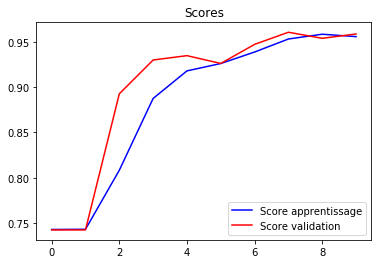

In [41]:
plot_scores(train)

In [42]:
y_cnn_classe = y_cnn.argmax(axis=-1)
y_test_classe = y_test.argmax(axis=-1)

[[254   8]
 [ 15 767]]


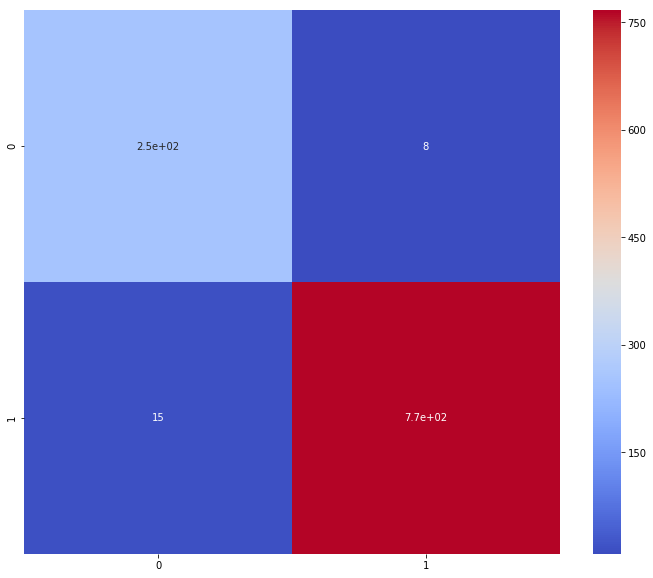

In [43]:
cm = confusion_matrix(y_cnn_classe,y_test_classe)
print(cm)
plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, cmap="coolwarm")

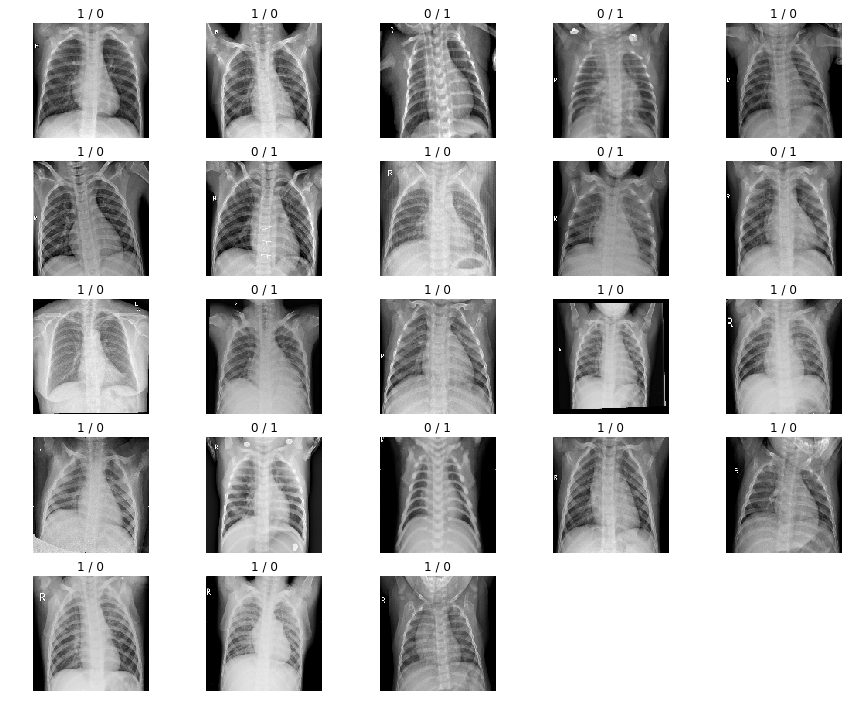

In [44]:
import random

plt.figure(figsize=(15,25))
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (np.argmax(y_cnn[j])!= np.argmax(y_test[j])) & (i<50):
        plt.subplot(10,5,i)
        plt.axis('off')
        plt.imshow(X_test[j], cmap='Greys')
        pred_classe = y_cnn[j].argmax(axis=-1)
        plt.title('%d / %d' % (y_cnn_classe[j], y_test_classe[j]))
        i+=1

Le modèle entrainé peut être sauvegardé :

In [45]:
model.save('mnist_cnn2.h5')

On peut ensuite utiliser le modèle sans recommencer l'entraînement :

In [46]:
new_model = load_model('mnist_cnn2.h5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 78400)            

In [47]:
scores = new_model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 95.88%


# END